In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.data import split_train_test

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("~\Desktop\JOTFORM\Summer2023\Anomaly-Detection\data\grouped_data.csv", index_col="date", parse_dates=True, squeeze=True)
industries = pd.read_csv("~\Desktop\JOTFORM\Summer2023\Anomaly-Detection\data\industry_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6902 entries, 2023-01-01 to 2023-07-22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cluster      6902 non-null   object
 1   keyword_sum  6902 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 161.8+ KB


In [5]:
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   industry  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes


### Feature Extraction

In [6]:
data['DateTime'] = data.index
data['DayOfTheWeek'] = data['DateTime'].dt.dayofweek
data['WeekDay'] = (data['DayOfTheWeek'] < 5).astype(int)
data['time_epoch'] = (data['DateTime'].astype(np.int64)/100000000000).astype(np.int64)
data = data.drop(columns= "DateTime")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6902 entries, 2023-01-01 to 2023-07-22
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cluster       6902 non-null   object
 1   keyword_sum   6902 non-null   int64 
 2   DayOfTheWeek  6902 non-null   int64 
 3   WeekDay       6902 non-null   int32 
 4   time_epoch    6902 non-null   int64 
dtypes: int32(1), int64(3), object(1)
memory usage: 296.6+ KB


In [8]:
df_list = []

In [9]:
for cluster in industries["industry"]:
    cluster_data = data[data['cluster'] == cluster]
    df_list.append(cluster_data)

In [10]:
updated_df_list = []

In [11]:
for df in df_list:
    updated_df = validate_series(df)
    updated_df_list.append(updated_df)

In [12]:
idx = pd.IndexSlice

In [13]:
updated_df_list[0].head()

cluster  keyword_sum  DayOfTheWeek  WeekDay  time_epoch
date                                                                     
2023-01-01  accommodation        18571             6        0    16725312
2023-01-02  accommodation        54716             0        1    16726176
2023-01-03  accommodation        80031             1        1    16727040
2023-01-04  accommodation        78300             2        1    16727904
2023-01-05  accommodation        75344             3        1    16728768

### ANOMALY DETECTION <br>
adtk - IF - Gaussian

adtk <br>
Threshold + Seasonal + Quantile

In [14]:
from adtk.detector import ThresholdAD
from adtk.detector import SeasonalAD
from adtk.detector import QuantileAD

In [15]:
anomalies_threshold = []
anomalies_seasonal = []
anomalies_quantile = []

In [16]:
for new_df in updated_df_list:
    df = new_df["keyword_sum"]
    df = pd.DataFrame(df)
    mean = df['keyword_sum'].mean()
    std = df['keyword_sum'].std()

    upper_control_limit = mean + 1.75* std
    lower_control_limit = mean - 1.75 * std
    threshold_ad = ThresholdAD(high=upper_control_limit, low=lower_control_limit)
    anomalies_t = threshold_ad.detect(df)
    anomalies_threshold.append(anomalies_t)
    seasonal_ad = SeasonalAD()
    anomalies_s = seasonal_ad.fit_detect(df)
    anomalies_seasonal.append(anomalies_s)

    quantile_ad = QuantileAD(high=0.99, low=0.01)
    anomalies_q = quantile_ad.fit_detect(df)
    anomalies_quantile.append(anomalies_q)


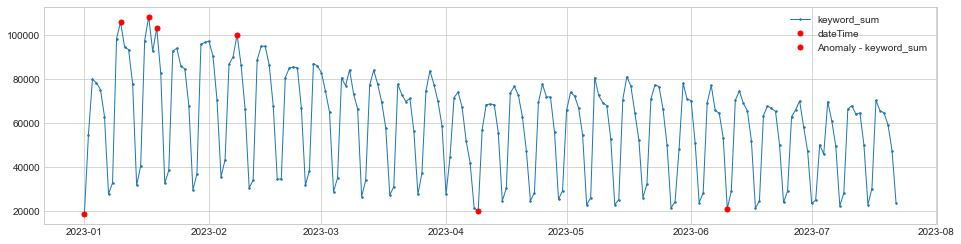

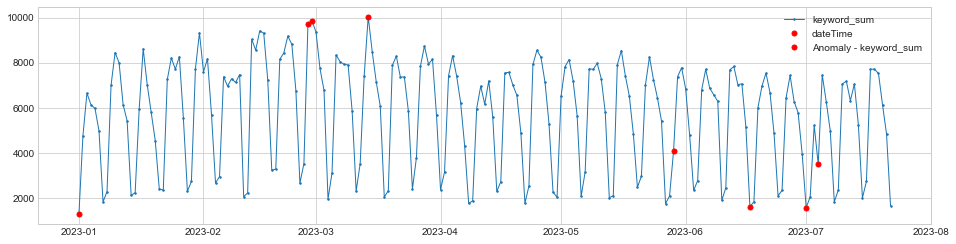

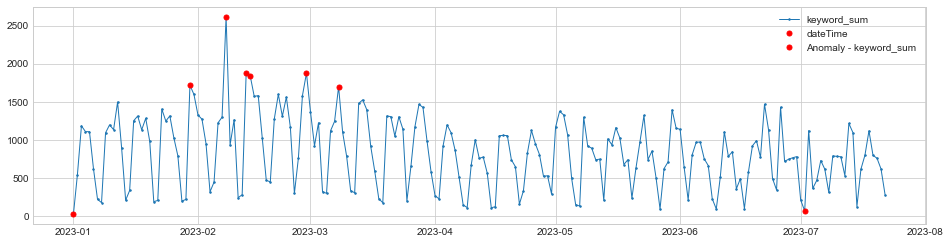

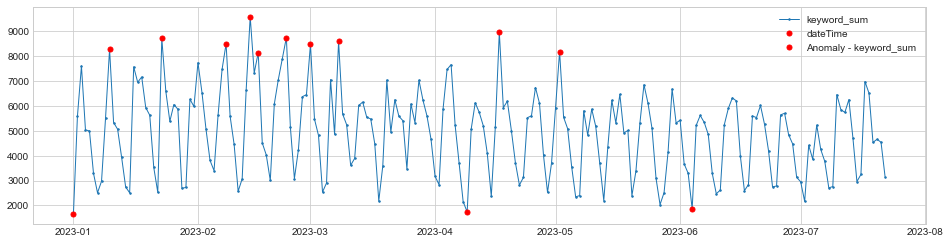

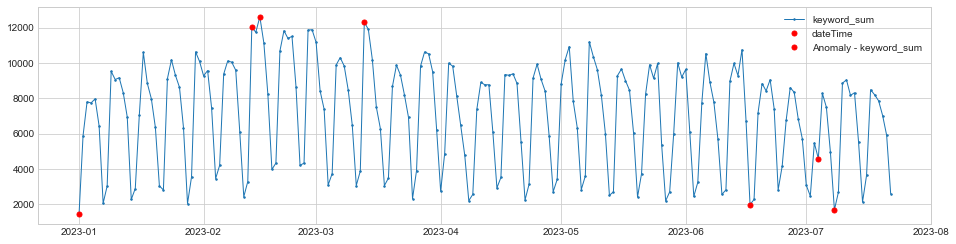

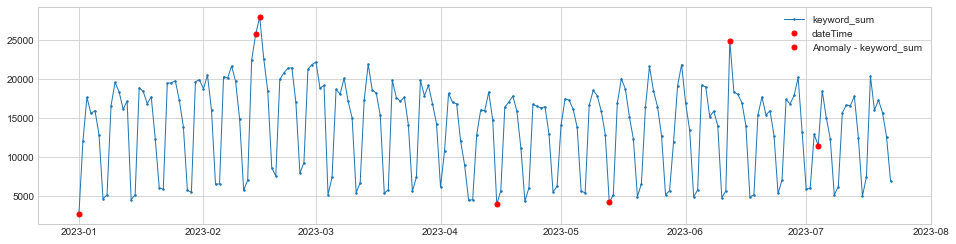

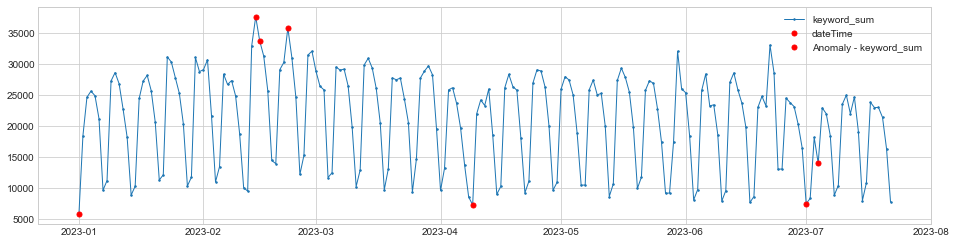

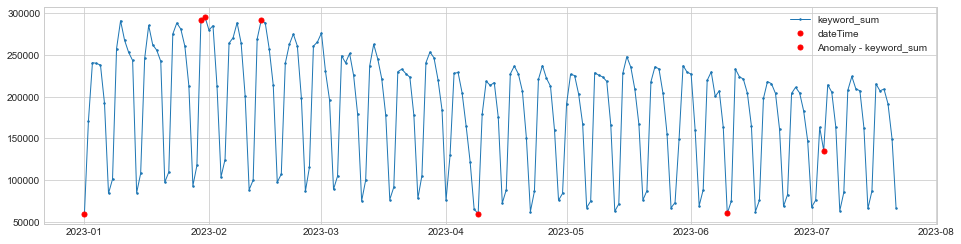

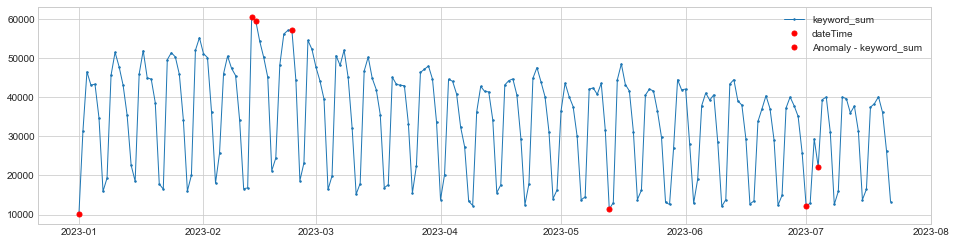

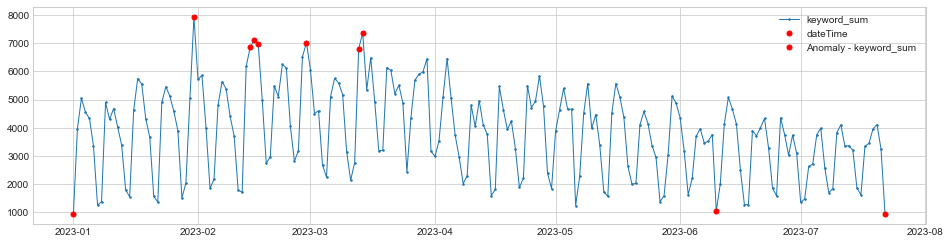

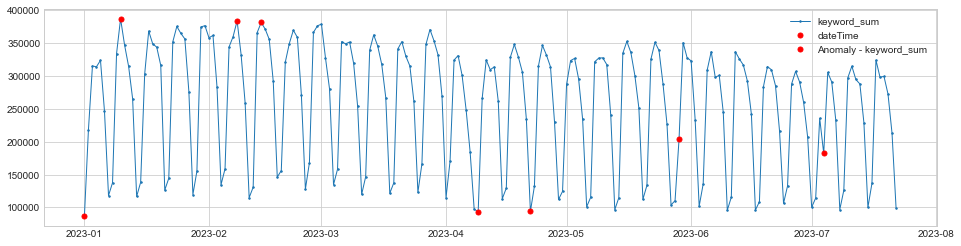

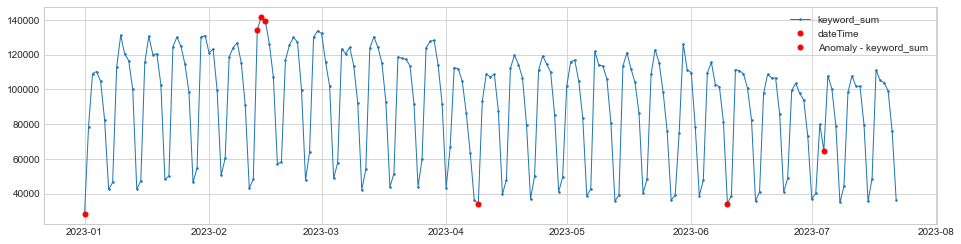

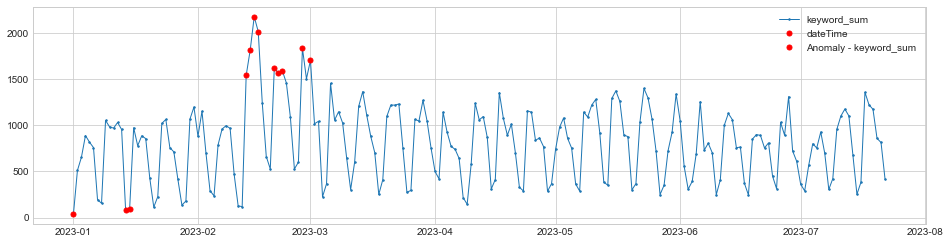

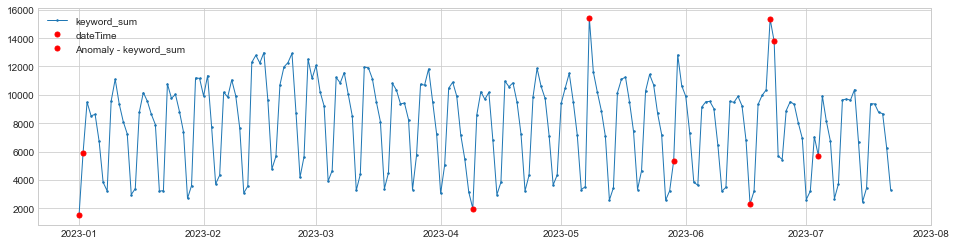

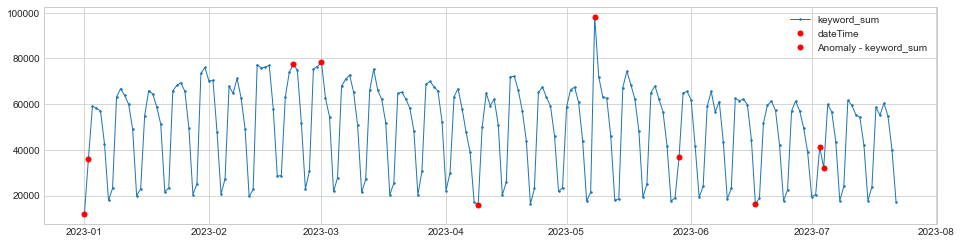

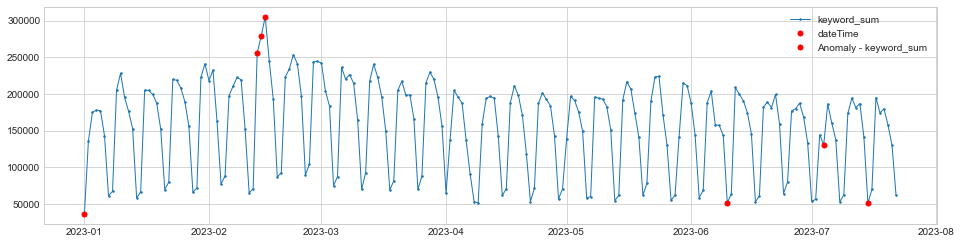

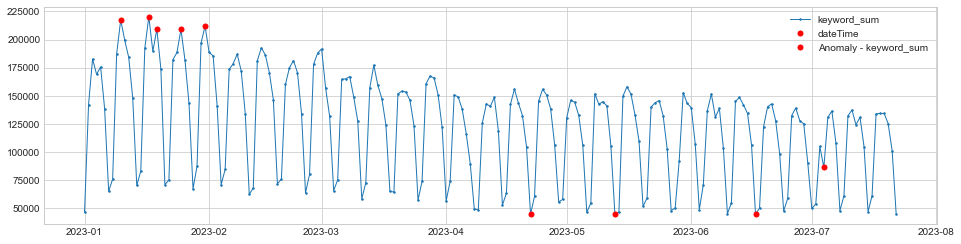

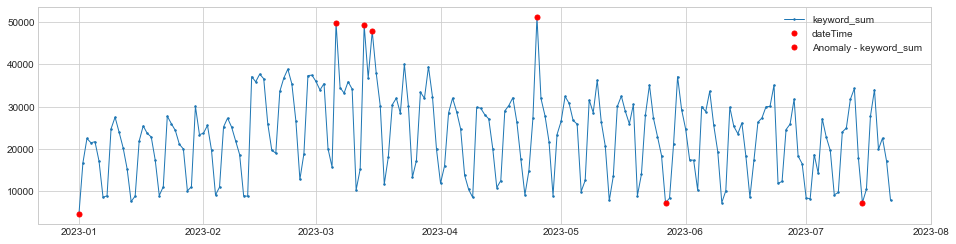

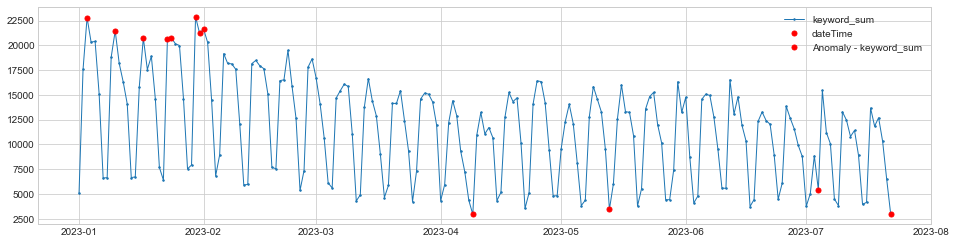

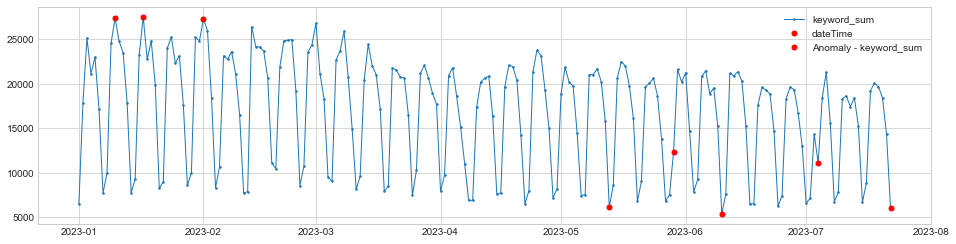

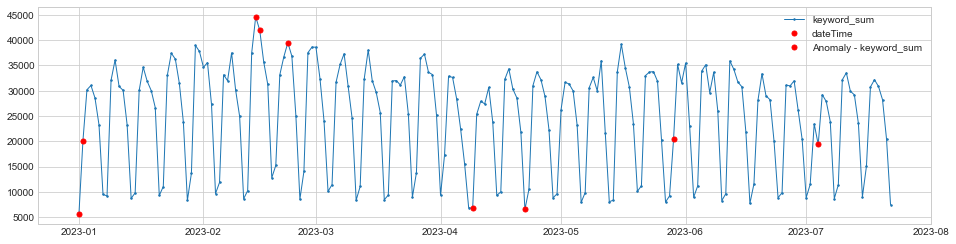

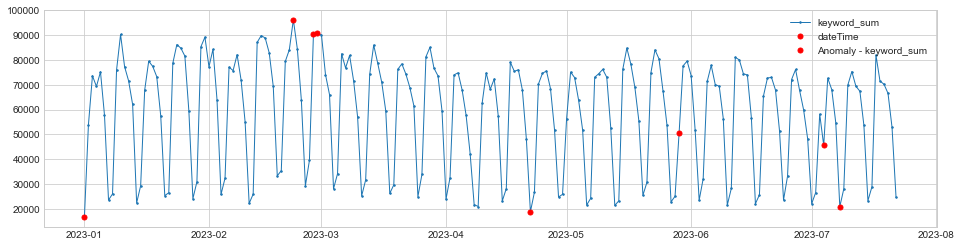

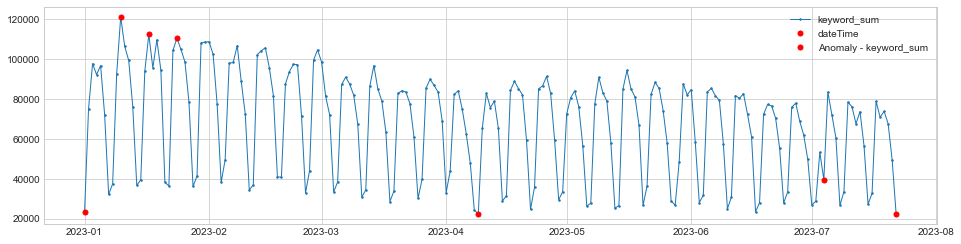

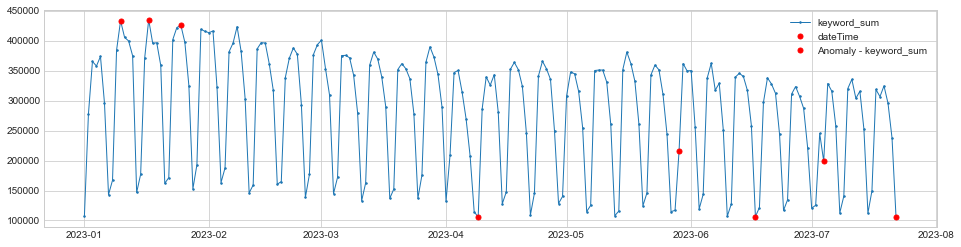

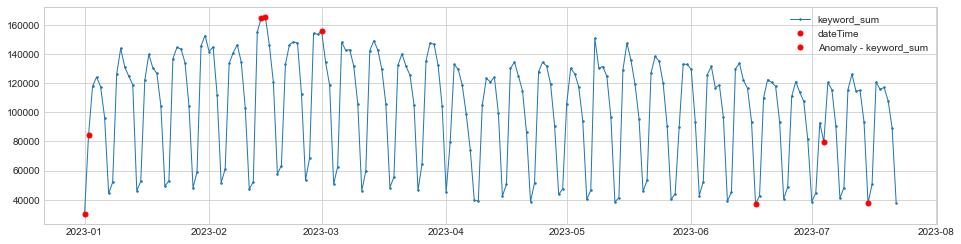

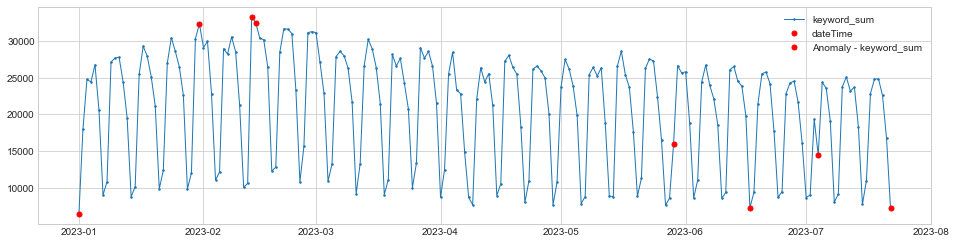

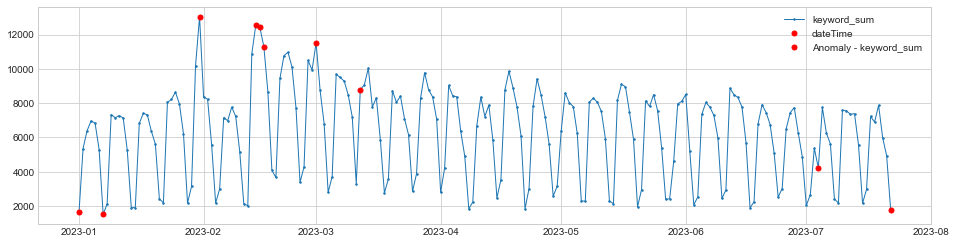

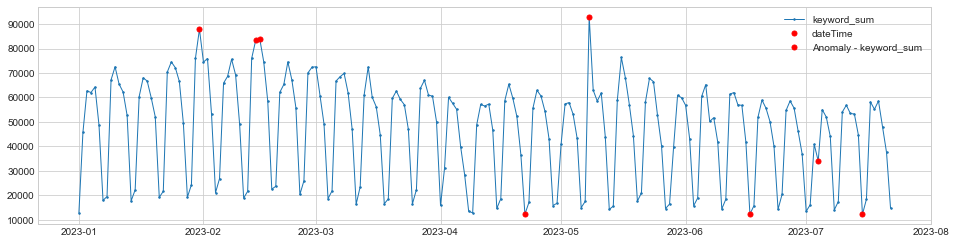

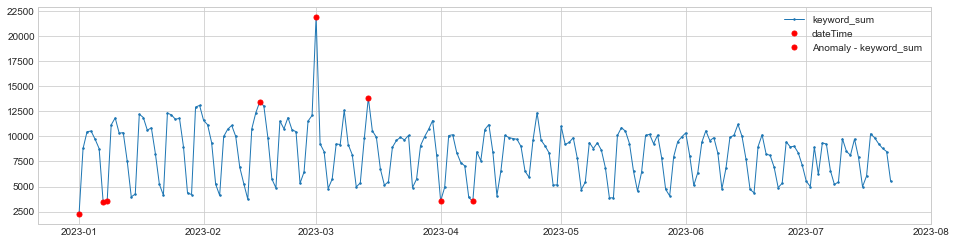

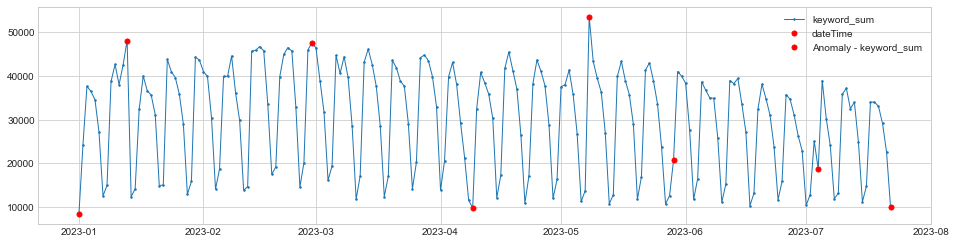

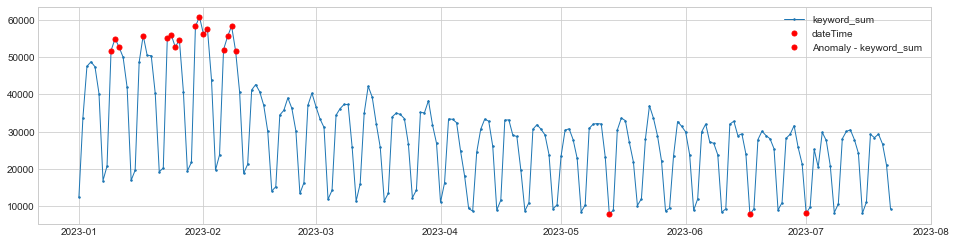

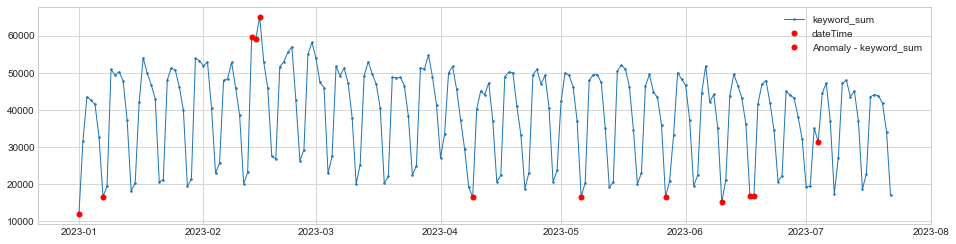

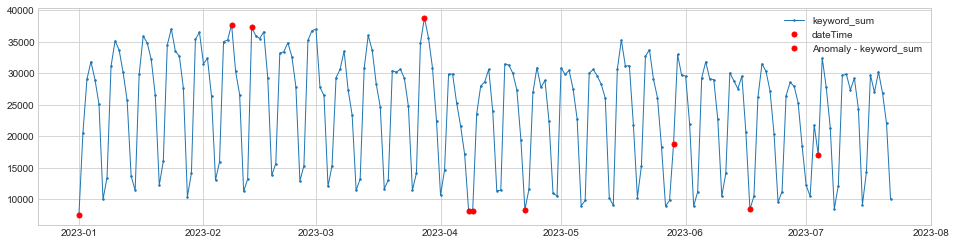

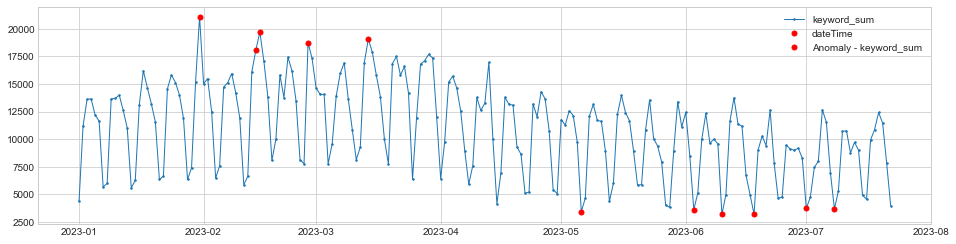

In [17]:
for i in range(0,34):
    df = updated_df_list[i]
    a_t = anomalies_threshold[i]
    a_s = anomalies_seasonal[i]
    a_q = anomalies_quantile[i]

    df.loc[:,'anomaly'] = False
    count = 0
    for index, row in df.iterrows():
        t = a_t.loc[index, 'keyword_sum']
        s = a_s.loc[index, 'keyword_sum']
        q = a_q.loc[index, 'keyword_sum']
        anomaly_value = t or s or q
        if anomaly_value:
            count += 1
        df.at[index, 'anomaly'] = anomaly_value

    df["dateTime"] = df.index

    anomalies = pd.DataFrame(df.loc[:,["dateTime","anomaly"]])
    anomalies["dateTime"]= pd.to_datetime(anomalies["dateTime"])
    updated_df_list[i] = df.merge(anomalies, left_index=True, right_index=True, how='outer')
    anomalies.rename(columns={'anomaly': 'keyword_sum'}, inplace=True)
    anomalies['keyword_sum'] = anomalies['keyword_sum'].astype(bool)

    plot(df.loc[:,"keyword_sum"], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [18]:
for i in range(len(updated_df_list)):
    df = updated_df_list[i]
    df = df.drop(columns = "anomaly_y")
    df = df.drop(columns = "dateTime_y")
    df.rename(columns={'anomaly_x': 'anomaly_adtk'}, inplace=True)
    df.rename(columns={'dateTime_x': 'dateTime'}, inplace=True)
    updated_df_list[i] = df

Isolation Forest

In [19]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing

In [20]:
outliers_fraction = 0.01

In [21]:
for i in range(len(updated_df_list)):
    df = updated_df_list[i]
    data = df[['keyword_sum', 'DayOfTheWeek', 'WeekDay']]
    data.reset_index(drop=True, inplace=True)
    data = pd.DataFrame(data)
    min_max_scaler = preprocessing.StandardScaler()

    scaled_data = min_max_scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    data = pd.DataFrame(scaled_df)
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    data["anomaly_if"] = pd.DataFrame(model.predict(data))

    data["anomaly_if"] = data["anomaly_if"].map( {1: 0, -1: 1}) 
    data.set_index(df['dateTime'], inplace=True)

    data["anomaly_if"] = data["anomaly_if"].apply(lambda x: True if x == 1 else False)

    updated_df_list[i] = df.merge(data["anomaly_if"], left_index=True, right_index=True, how='outer')
    

In [22]:
updated_df_list[0].head()

cluster  keyword_sum  DayOfTheWeek  WeekDay  time_epoch  \
date                                                                        
2023-01-01  accommodation        18571             6        0    16725312   
2023-01-02  accommodation        54716             0        1    16726176   
2023-01-03  accommodation        80031             1        1    16727040   
2023-01-04  accommodation        78300             2        1    16727904   
2023-01-05  accommodation        75344             3        1    16728768   

            anomaly_adtk   dateTime  anomaly_if  
date                                             
2023-01-01          True 2023-01-01        True  
2023-01-02         False 2023-01-02       False  
2023-01-03         False 2023-01-03       False  
2023-01-04         False 2023-01-04       False  
2023-01-05         False 2023-01-05       False

Gaussian

In [23]:
from sklearn.covariance import EllipticEnvelope

In [24]:
for i in range(len(updated_df_list)):
    df = updated_df_list[i]

    df_class0 = df.loc[df['WeekDay'] == 0, 'keyword_sum'] #weekend
    df_class1 = df.loc[df['WeekDay'] == 1, 'keyword_sum'] #weekday

    envelope =  EllipticEnvelope(contamination = outliers_fraction) 
    X_train = df_class0.values.reshape(-1,1)
    envelope.fit(X_train)
    df_class0 = pd.DataFrame(df_class0)
    df_class0['deviation'] = envelope.decision_function(X_train)
    df_class0['anomaly'] = envelope.predict(X_train)

    envelope =  EllipticEnvelope(contamination = outliers_fraction) 
    X_train = df_class1.values.reshape(-1,1)
    envelope.fit(X_train)
    df_class1 = pd.DataFrame(df_class1)
    df_class1['deviation'] = envelope.decision_function(X_train)
    df_class1['anomaly'] = envelope.predict(X_train)

    df_class = pd.concat([df_class0, df_class1])
    df['anomaly_gaussian'] = df_class['anomaly'].values
    df['anomaly_gaussian'] = np.array(df['anomaly_gaussian'] == -1).astype(int)
    df['anomaly_gaussian'] = df['anomaly_gaussian'].apply(lambda x: True if x == 1 else False)

    updated_df_list[i] = df
 



In [25]:
updated_df_list[0].head()

cluster  keyword_sum  DayOfTheWeek  WeekDay  time_epoch  \
date                                                                        
2023-01-01  accommodation        18571             6        0    16725312   
2023-01-02  accommodation        54716             0        1    16726176   
2023-01-03  accommodation        80031             1        1    16727040   
2023-01-04  accommodation        78300             2        1    16727904   
2023-01-05  accommodation        75344             3        1    16728768   

            anomaly_adtk   dateTime  anomaly_if  anomaly_gaussian  
date                                                               
2023-01-01          True 2023-01-01        True             False  
2023-01-02         False 2023-01-02       False             False  
2023-01-03         False 2023-01-03       False             False  
2023-01-04         False 2023-01-04       False             False  
2023-01-05         False 2023-01-05       False             False

anomaly_adtk + anomaly_if + anomaly_gaussian = anomaly(label)

In [26]:
for i in range(0,34):
    df = updated_df_list[i]
    a_t = df.loc[:,"anomaly_adtk"]
    a_s = df.loc[:,"anomaly_if"]
    a_q = df.loc[:,"anomaly_gaussian"]

    df.loc[:,'anomaly'] = False
    count = 0
    for index, row in df.iterrows():
        t = a_t.loc[index]
        s = a_s.loc[index]
        q = a_q.loc[index]
        anomaly_value = t or s or q
        if anomaly_value:
            count += 1
        df.at[index, 'anomaly'] = anomaly_value
    updated_df_list[i] = df

In [27]:
updated_df_list[0].head()

cluster  keyword_sum  DayOfTheWeek  WeekDay  time_epoch  \
date                                                                        
2023-01-01  accommodation        18571             6        0    16725312   
2023-01-02  accommodation        54716             0        1    16726176   
2023-01-03  accommodation        80031             1        1    16727040   
2023-01-04  accommodation        78300             2        1    16727904   
2023-01-05  accommodation        75344             3        1    16728768   

            anomaly_adtk   dateTime  anomaly_if  anomaly_gaussian  anomaly  
date                                                                        
2023-01-01          True 2023-01-01        True             False     True  
2023-01-02         False 2023-01-02       False             False    False  
2023-01-03         False 2023-01-03       False             False    False  
2023-01-04         False 2023-01-04       False             False    False  
2023-01-05         False 2023-01-05       False             False    False

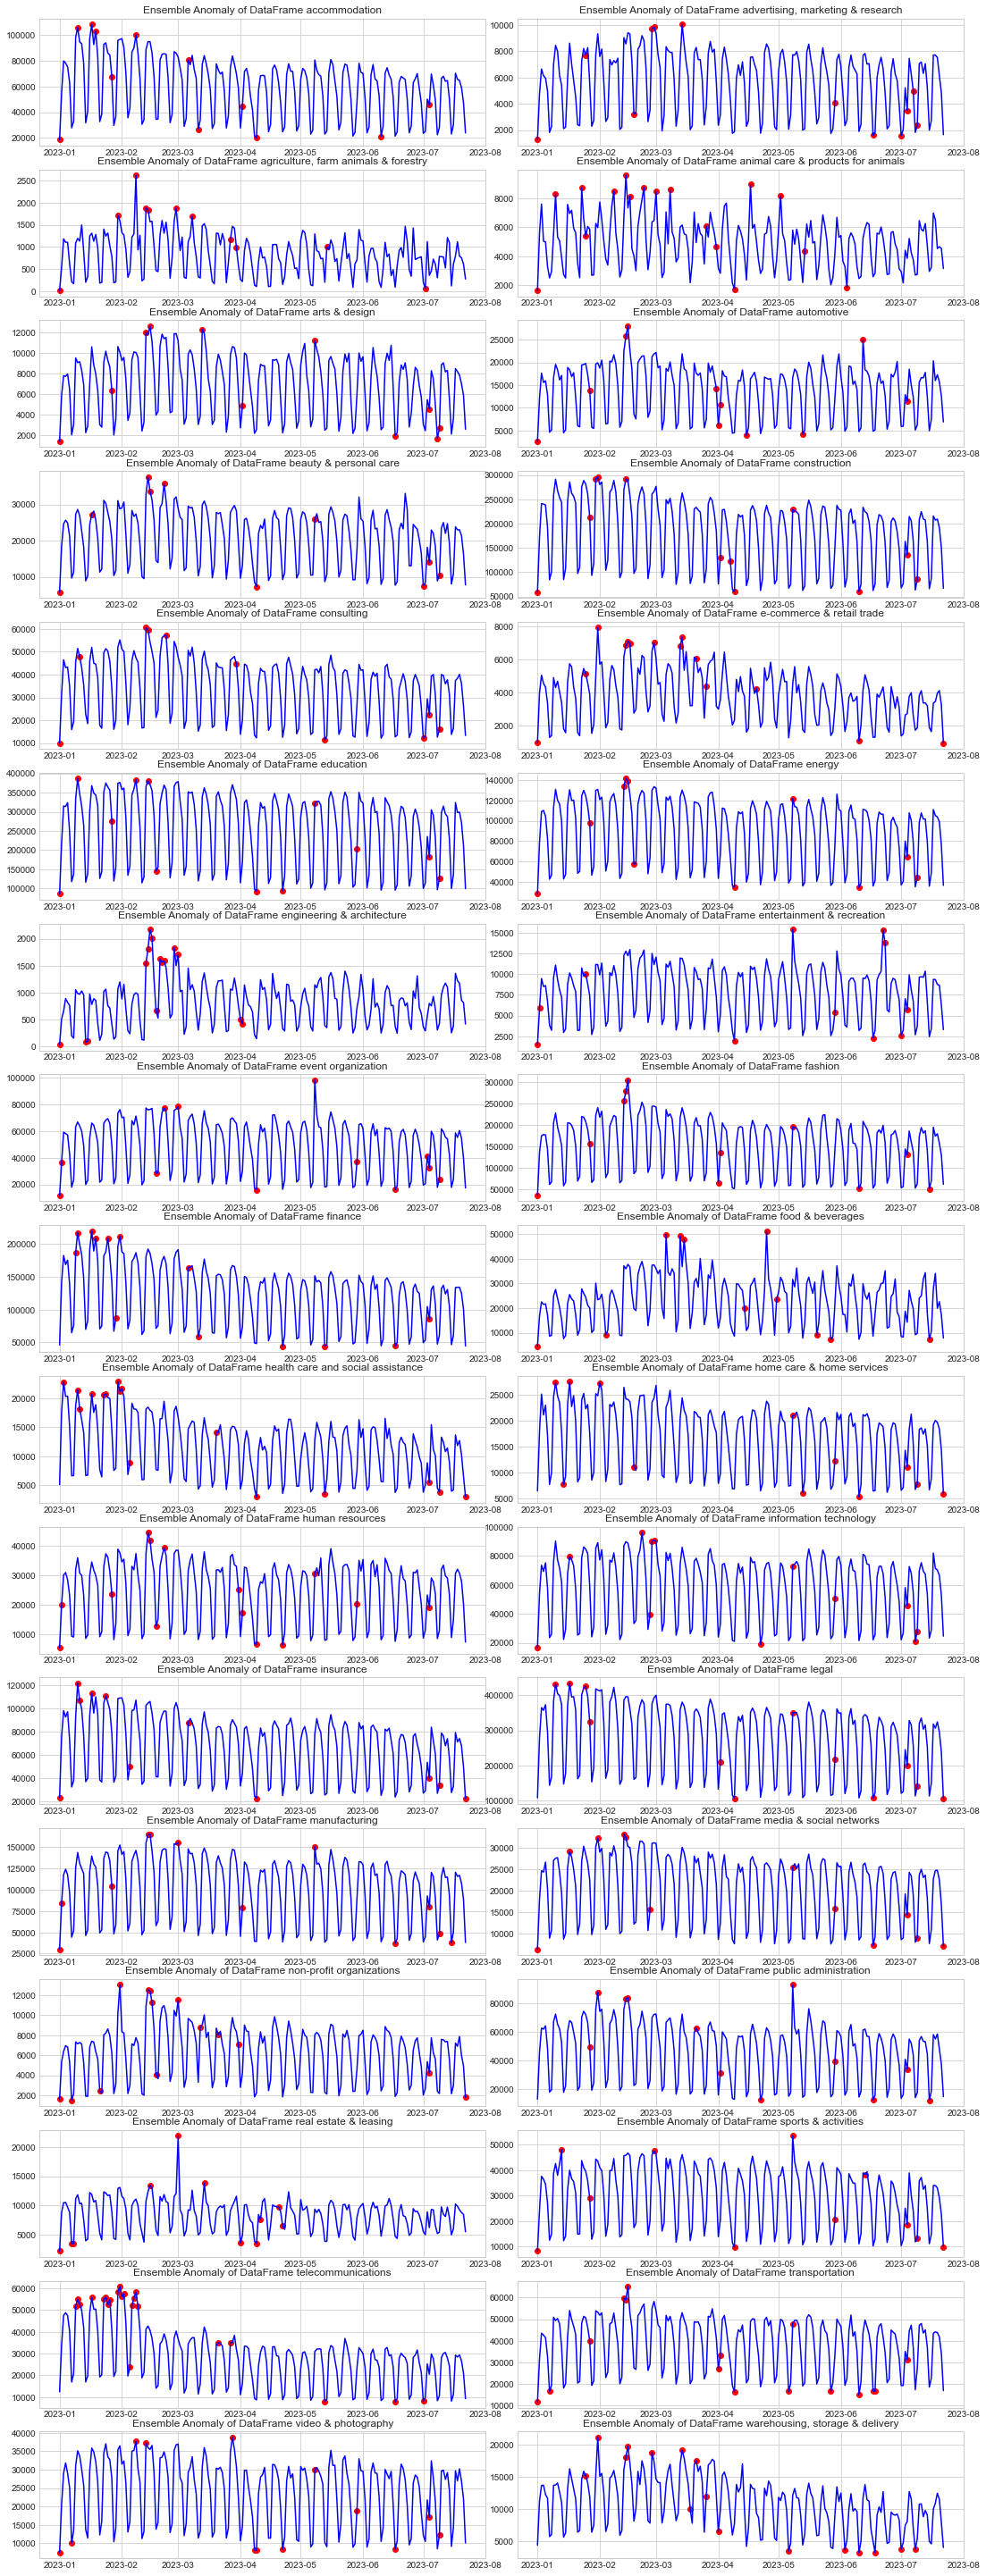

In [28]:
fig, axs = plt.subplots(17, 2, figsize=(15, 40))
fig.tight_layout()

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        index = i * 2 + j
        if index < len(updated_df_list):
            df = updated_df_list[index]
            n_df = df

            a = n_df.loc[n_df['anomaly'] == True] #anomaly

            ax.plot(n_df.index, n_df['keyword_sum'], color='blue')
            ax.scatter(a.index,a['keyword_sum'], color='red')
            cluster = n_df["cluster"].unique()
            ax.set_title(f'Ensemble Anomaly of DataFrame {cluster[0]}')
            
        else:
            ax.axis('off')  # Eğer dataframe kalmadıysa, bu hücreyi boş bırak

plt.show();

concatenation of all train dataset

In [29]:
merged_df = pd.concat(updated_df_list)

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6902 entries, 2023-01-01 to 2023-07-22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cluster           6902 non-null   object        
 1   keyword_sum       6902 non-null   int64         
 2   DayOfTheWeek      6902 non-null   int64         
 3   WeekDay           6902 non-null   int32         
 4   time_epoch        6902 non-null   int64         
 5   anomaly_adtk      6902 non-null   bool          
 6   dateTime          6902 non-null   datetime64[ns]
 7   anomaly_if        6902 non-null   bool          
 8   anomaly_gaussian  6902 non-null   bool          
 9   anomaly           6902 non-null   bool          
dtypes: bool(4), datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 377.5+ KB


enumeration of cluster

In [31]:
unique_clusters = sorted(set(merged_df['cluster']))
enum_clusters = {cluster: idx for idx, cluster in enumerate(unique_clusters)}

# Yeni sütunu DataFrame'e ekliyoruz
merged_df['enum_cluster'] = merged_df['cluster'].map(enum_clusters)

In [32]:
merged_df.sort_index(inplace=True)

In [33]:
start_date = datetime(2023,1,1)
end_date = datetime(2023,7,1)

In [34]:
train_dataframe = merged_df.iloc[0:6154,:]

In [35]:
test_dataframe = merged_df.iloc[6154:,:]

Machine Learning

In [36]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [37]:
X_train = train_dataframe[["keyword_sum","DayOfTheWeek","WeekDay","time_epoch", "enum_cluster"]]
y_train = pd.DataFrame(train_dataframe["anomaly"])

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6154 entries, 2023-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   keyword_sum   6154 non-null   int64
 1   DayOfTheWeek  6154 non-null   int64
 2   WeekDay       6154 non-null   int32
 3   time_epoch    6154 non-null   int64
 4   enum_cluster  6154 non-null   int64
dtypes: int32(1), int64(4)
memory usage: 264.4 KB


In [39]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6154 entries, 2023-01-01 to 2023-06-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   anomaly  6154 non-null   bool 
dtypes: bool(1)
memory usage: 54.1 KB


In [40]:
X_test = test_dataframe[["keyword_sum","DayOfTheWeek","WeekDay","time_epoch", "enum_cluster"]]
y_test = pd.DataFrame(test_dataframe["anomaly"])

In [41]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, y_train, y_train)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:15<00:00,  1.81it/s]


In [42]:
models_train

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
ExtraTreeClassifier                1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
BaggingClassifier                  0.99               0.94     0.94      0.99   
XGBClassifier                      0.99               0.89     0.89      0.99   
LGBMClassifier                     0.98               0.81     0.81      0.97   
NearestCentroid                    0.60               0.64     0.64      0.70   
LabelPropagation                   0.95               0.60     0.60      0.94   
PassiveAggressiveClassifier        0.69               0.59     0.59      0.77   
LabelSpreading                     0.95               0.58     0.58      0.93   
KNeighborsClassifier               0.95               0.56     0.56      0.93   
AdaBoostClassifier                 0.94               0.54     0.54      0.92   
LinearDiscriminantAnalysis         0.94               0.50     0.50      0.91   
LogisticRegression                 0.94               0.50     0.50      0.91   
GaussianNB                         0.94               0.50     0.50      0.91   
DummyClassifier                    0.94               0.50     0.50      0.91   
Perceptron                         0.94               0.50     0.50      0.91   
QuadraticDiscriminantAnalysis      0.94               0.50     0.50      0.91   
CalibratedClassifierCV             0.94               0.50     0.50      0.91   
RidgeClassifier                    0.94               0.50     0.50      0.91   
RidgeClassifierCV                  0.94               0.50     0.50      0.91   
SGDClassifier                      0.94               0.50     0.50      0.91   
SVC                                0.94               0.50     0.50      0.91   
BernoulliNB                        0.94               0.50     0.50      0.91   
LinearSVC                          0.94               0.50     0.50      0.91   

                               Time Taken  
Model                                      
RandomForestClassifier               1.52  
DecisionTreeClassifier               0.06  
ExtraTreeClassifier                  0.07  
ExtraTreesClassifier                 0.88  
BaggingClassifier                    0.26  
XGBClassifier                        1.11  
LGBMClassifier                       0.16  
NearestCentroid                      0.06  
LabelPropagation                     2.71  
PassiveAggressiveClassifier          0.06  
LabelSpreading                       3.55  
KNeighborsClassifier                 0.32  
AdaBoostClassifier                   0.58  
LinearDiscriminantAnalysis           0.05  
LogisticRegression                   0.09  
GaussianNB                           0.05  
DummyClassifier                      0.05  
Perceptron                           0.06  
QuadraticDiscriminantAnalysis        0.07  
CalibratedClassifierCV               1.15  
RidgeClassifier                      0.06  
RidgeClassifierCV                    0.04  
SGDClassifier                        0.05  
SVC                                  2.60  
BernoulliNB                          0.07  
LinearSVC                            0.25

I will try RandomForestClassifier, XGBClassifier, LogisticRegression and SVC

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [44]:
models = [
RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
SVC(),
LogisticRegression(random_state=42),
XGBClassifier(n_estimators=100, random_state=42)
]

In [45]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [46]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
max_accuracy = cv_df.groupby('model_name').accuracy.max()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy,max_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy','Accuracy', 'Standard deviation']
acc

Mean Accuracy  Accuracy  Standard deviation
model_name                                                         
LogisticRegression               0.94      0.94                0.00
RandomForestClassifier           0.75      0.94                0.38
SVC                              0.94      0.94                0.00
XGBClassifier                    0.29      0.94                0.38

I prefer RandomForestClassifier

In [47]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [48]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= ["True", "False"]))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

        True       0.91      1.00      0.95       681
       False       0.00      0.00      0.00        67

    accuracy                           0.91       748
   macro avg       0.46      0.50      0.48       748
weighted avg       0.83      0.91      0.87       748



In [49]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [50]:
y_pred = model.predict(X_test)

In [51]:
y_pred = pd.DataFrame(y_pred)
y_pred.set_index(y_test.index, inplace=True)

In [52]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2023-07-01 to 2023-07-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       748 non-null    bool 
dtypes: bool(1)
memory usage: 6.6 KB


In [53]:
df_list = []

In [54]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2023-07-01 to 2023-07-22
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   keyword_sum   748 non-null    int64
 1   DayOfTheWeek  748 non-null    int64
 2   WeekDay       748 non-null    int32
 3   time_epoch    748 non-null    int64
 4   enum_cluster  748 non-null    int64
dtypes: int32(1), int64(4)
memory usage: 32.1 KB


In [55]:
# y_pred ile X_test'i birleştir
test_predicted = pd.concat([X_test, y_pred], axis=1)

In [56]:
test_predicted.head(10)

keyword_sum  DayOfTheWeek  WeekDay  time_epoch  enum_cluster  \
date                                                                       
2023-07-01          361             5        0    16881696            12   
2023-07-01         7502             5        0    16881696             6   
2023-07-01         1565             5        0    16881696             1   
2023-07-01        12199             5        0    16881696            32   
2023-07-01       100232             5        0    16881696            10   
2023-07-01         8156             5        0    16881696            30   
2023-07-01        53581             5        0    16881696            15   
2023-07-01        49752             5        0    16881696            16   
2023-07-01         6597             5        0    16881696            19   
2023-07-01         3070             5        0    16881696             4   

                0  
date               
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False  
2023-07-01  False

In [57]:
enum_cluster_list = []

In [58]:
enum_cluster_list = sorted(test_predicted.enum_cluster.unique().tolist())

In [59]:
enum_cluster_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

In [60]:
for cluster in industries["industry"]:
    cluster_data = test_dataframe[test_dataframe['cluster'] == cluster]
    df_list.append(cluster_data)

In [61]:
df_list_predicted = []

In [62]:
for cluster in enum_cluster_list:
    cluster_data = test_predicted[test_predicted['enum_cluster'] == cluster]
    cluster_data['anomaly'] = cluster_data.iloc[:,-1].values
    df_list_predicted.append(cluster_data)

In [63]:
df_list_predicted[0].head()

keyword_sum  DayOfTheWeek  WeekDay  time_epoch  enum_cluster  \
date                                                                       
2023-07-01        23615             5        0    16881696             0   
2023-07-02        25044             6        0    16882560             0   
2023-07-03        50230             0        1    16883424             0   
2023-07-04        45953             1        1    16884288             0   
2023-07-05        69818             2        1    16885152             0   

                0  anomaly  
date                        
2023-07-01  False    False  
2023-07-02  False    False  
2023-07-03  False    False  
2023-07-04  False    False  
2023-07-05  False    False

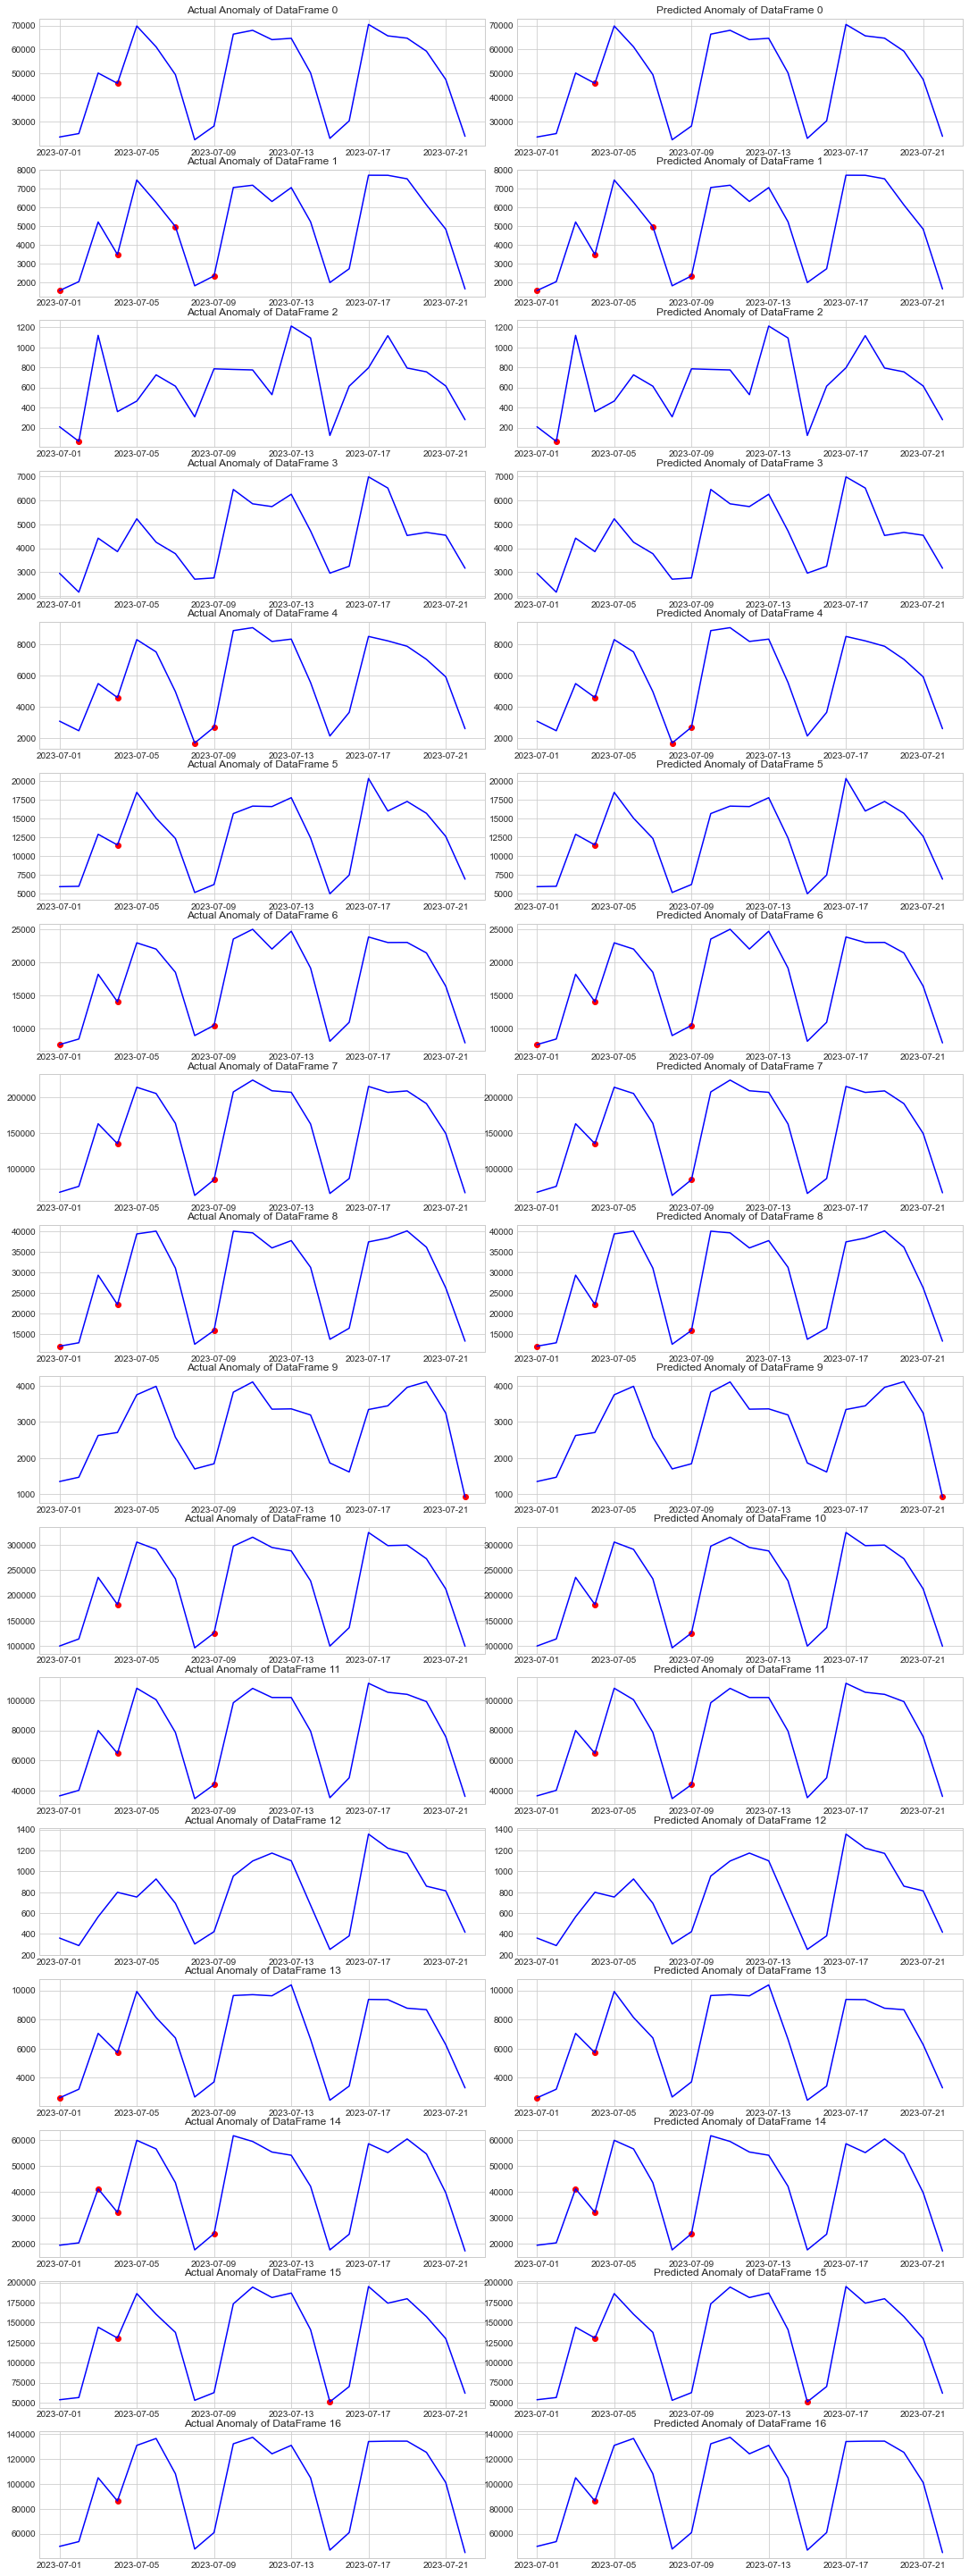

In [64]:
fig, axs = plt.subplots(17, 2, figsize=(15, 40))
fig.tight_layout()

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        index = i * 2 + j
        if index < 2*len(df_list):
            if j % 2 == 0:  # Tek sayı ise df_list kullan
                df = df_list[i]
            else:  # Çift sayı ise df_list_predict kullan
                df = df_list[i]
                
            n_df = df.copy()
            cluster = n_df["enum_cluster"].unique()
            a = n_df.loc[n_df['anomaly'] == True] #anomaly

            ax.plot(n_df.index, n_df['keyword_sum'], color='blue')
            ax.scatter(a.index,a['keyword_sum'], color='red')

            if index % 2 == 0:  # Tek sayı ise df_list kullan
                ax.set_title(f'Actual Anomaly of DataFrame {cluster[0]}')
            else:  # Çift sayı ise df_list_predict kullan
                ax.set_title(f'Predicted Anomaly of DataFrame {cluster[0]}')
            
        else:
            ax.axis('off')  # Eğer dataframe kalmadıysa, bu hücreyi boş bırak

plt.show();